In [127]:
import argparse
import logging
import numpy as np
from astropy.io import fits
from astropy import stats
from astropy import time
import matplotlib.pyplot as plt
import glob

In [131]:
inputdirectory='/Users/dharbeck/lco/cosmos/COSMOS_HDR_PWR2V/*-[bx]00.fits.fz'
inputdirectory='/Users/dharbeck/lco/cosmos/ptc_cms/*-[bx]00.fits.fz'

inputfiles = glob.glob (inputdirectory)

In [132]:
def get_level_exptime_for_file (fitsfilename, minx=3000,maxx=4000,miny=3000,maxy=4000):
    f = fits.open(fitsfilename)
    data = f['SCI'].data[miny:maxy,minx:maxx]
    exptime = f['SCI'].header['EXPTIME']
    level = np.median (data)
    f.close()
    del data
    return exptime, level

exptimes = []
levels = []

for file in inputfiles:
    exptime,level = get_level_exptime_for_file(file)
    exptimes.append (exptime)
    levels.append (level)
exptimes = np.asarray (exptimes)
levels = np.asarray (levels)

[35. 35.] 35.0
[ 576. 5207.   70.   28.   12. 2059.  370.  573.  239. 3619.   12.  121.
 1302.  370. 2059.   12.   28.   70. 5208.  577. 1302.  121.   12. 3619.
  239.] [1.01217123 6.9989774  0.1820786  0.10161954 0.07019503 2.98727076
 0.69683072 1.00772742 0.48251284 5.00331038 0.07019503 0.27629386
 2.01287809 0.69683072 2.98727076 0.07019503 0.10161954 0.1820786
 7.00012543 1.01365165 2.01287809 0.27629386 0.07019503 5.00331038
 0.48251284]
texp3idx  5


Text(0, 0.5, 'Flux:   Image Level / Exptime')

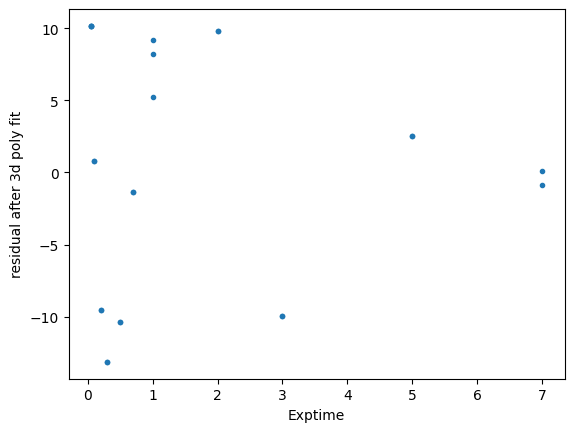

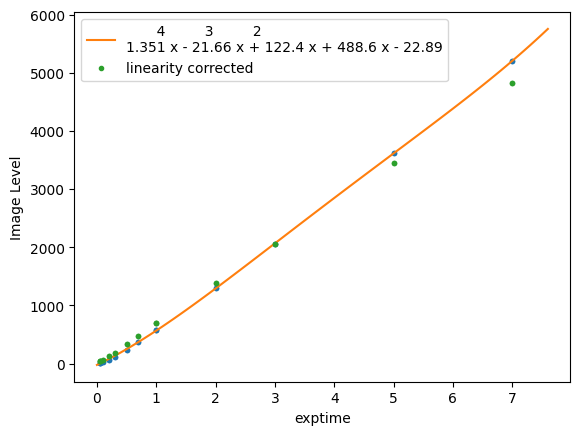

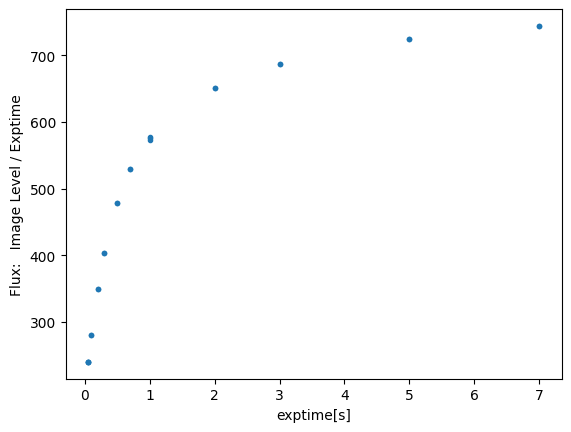

In [153]:
biaslevel = np.average (levels [exptimes == 0])
print (levels [exptimes == 0], biaslevel)

corrected_levels = levels - biaslevel
corrected_levels = corrected_levels[exptimes > 0]
corrected_exptimes = exptimes[exptimes >0]

z = np.polyfit(corrected_exptimes, corrected_levels, 4)
p = np.poly1d(z)
fitbase = np.arange (0,np.max(exptimes)*1.1, 0.1)
fitteddata = p(fitbase)


plt.figure()
plt.plot (corrected_exptimes, corrected_levels - p(corrected_exptimes), '.')
plt.xlabel ("Exptime")
plt.ylabel ("residual after 3d poly fit")

plt.figure()
plt.plot (corrected_exptimes, corrected_levels,'.', label='raw data')
plt.plot (fitbase, fitteddata, label=f'{p}')
plt.xlabel ("exptime")
plt.ylabel ("Image Level")


lincorrected_levels = corrected_levels * 0

for ii in range (len(corrected_levels)):
    root = (p-corrected_levels[ii]).roots
    root = root[np.isreal(root)]
    root = root[root >= 0]
    if len (root) > 0:
        lincorrected_levels[ii] = np.real(root[0])

print (corrected_levels, lincorrected_levels)
        
texp3idx = np.where(corrected_exptimes == 3)[0][0]
print ("texp3idx ", texp3idx)
lincorrected_levels = lincorrected_levels * corrected_levels[texp3idx] / lincorrected_levels[texp3idx]
plt.plot (corrected_exptimes, lincorrected_levels,'.', label="linearity corrected")
plt.legend()

plt.figure ()
plt.plot (corrected_exptimes, corrected_levels / corrected_exptimes, '.' )
plt.xlabel ("exptime[s]")
plt.ylabel ("Flux:   Image Level / Exptime")
